# Week 2 Assignment - PRA3024
# Michail-Georgios Papachristos 
#i6166863

In this assignment, several Application Programming Interface(API) tools are obtained via the Exo.mast website and are used to plot the light curve for 2 exoplanets(HR 858 c and LHS 3844 b) detected by the Transitioning Exoplanet Survey Satellite(TESS). Furthermore, the astroquery python catalogue is used to create a cutout of TESS Full Frame Images(FFI) for those 2 same exoplanets. This whole process is done through python.

Code and relevant information taken from: 

https://github.com/spacetelescope/notebooks/blob/master/notebooks/MAST/TESS/beginner_tess_exomast/beginner_tess_exomast.ipynb

https://github.com/spacetelescope/notebooks/blob/master/notebooks/MAST/TESS/interm_tesscut_astroquery/interm_tesscut_astroquery.ipynb

https://github.com/spacetelescope/tessworkshop_tutorials/blob/master/tesscut_exomast/TESScut_ExoMAST_Tutorial.ipynb

#Plotting TESS Light Curves for 2 Exoplanets

#Exoplanet 1: HR 858 c

First, the following python packages are imported and astroquery is installed since all of those things are required for the assignment:

In [0]:
!pip install astroquery

import numpy as np
import requests
import matplotlib.pyplot as plt
import pandas as p
from IPython.display import display, HTML
from astroquery.mast import Catalogs
from astroquery.mast import Tesscut
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astropy.io import fits
import matplotlib.pyplot as plt

%matplotlib inline

planeturl = "https://exo.mast.stsci.edu/api/v0.1/exoplanets/"
dvurl = "https://exo.mast.stsci.edu/api/v0.1/dvdata/tess/"
header={}


     |████████████████████████████████| 4.5MB 2.8MB/s 
     |████████████████████████████████| 2.3MB 44.8MB/s 
  Created wheel for astroquery: filename=astroquery-0.4-cp36-none-any.whl size=3582510 sha256=ec4e0a8508909cf5e53c22e58d2c18ab3f7bf2950aa60d2615a85c0b42fdc052
  Stored in directory: /root/.cache/pip/wheels/a3/6d/9d/f6ceddc68de0e4b7a64b56d6e8c8075e6ef6377ec9c05ce128
Successfully built astroquery


Afterwards, a query is made that takes the input of a name of a planet and outputs a json.

In [0]:
planet_name = "HR 858 c"

url = planeturl + "/identifiers/"

myparams = {"name":planet_name}

r = requests.get(url = url, params = myparams, headers = header)
print(r.headers.get('content-type'))

application/json; charset=UTF-8


This json is taken and converted to a python dictionary. That dictionary includes many properties of the exoplanet and the star associated with it. Two variables(ticid, tce) are made which equal the tessID and tessTCE properties of the dictionary. 

In [0]:
planet_names = r.json()
ticid = planet_names['tessID']
tce = planet_names['tessTCE']
planet_names

{'canonicalName': 'HR 858 c',
 'dec': -30.81452,
 'keplerID': None,
 'keplerTCE': None,
 'planetNames': [],
 'ra': 42.98436,
 'starName': 'HR 858',
 'tessID': 178155732,
 'tessTCE': 'TCE_1'}

Through the NExScl exoplanet tables, the properties of the planet can be extrapolated.

In [0]:
url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header)

planet_prop = r.json()

print("Catalog 1: " + planet_prop[0]['catalog_name'])
planet_prop[0].keys()
print("HR 858 c Properties")
print("Stellar Mass %f %s" % (planet_prop[0]['Ms'], planet_prop[0]['Ms_unit'] ) )
print("Planet Mass %f %s" % (planet_prop[0]['Mp'], planet_prop[0]['Mp_unit'] ) )
print("Planet Mass Reference: %s" % (planet_prop[0]['Mp_ref']))

Catalog 1: nexsci
HR 858 c Properties
Stellar Mass 1.150000 M_sun
Planet Mass 0.013900 M_Jupiter
Planet Mass Reference: Calculated Value


TESS goes through a 2 minute candence-data for transit signals identified with its TPS(Transit Planet Search) module. For every identified signal that exceeds a nominal signal-to-noise requirement, a TCE(Threshold Crossing Event) consisting of periodic signals is created. TCE's are usually indicative of eclipsing binaries around a star or transiting planets passing in front of a star. Moreover, the header information from the primary header and the data headed associated with the specific TCE of the ephemeris of a specific planet needs to be retrieved. It should be mentioned that a lot of the data might be in multiple TESS sectors. However, this code can be used to find in which sector's search is the data located and print the primary and dv data header.

In [0]:
url = dvurl + str(ticid) + '/tces/'
myparams = {"tce" : tce}

r = requests.get(url = url, params = myparams, headers = header)
sectorInfo = r.json()

sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
sectors
url = dvurl + str(ticid) + '/info/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tceInfo = r.json()
tceInfo.keys()
tceInfo['DV Data Header'].keys()

print("TIC: %s" % tceInfo['DV Primary Header']['OBJECT'])
print("Planet Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])

TIC: TIC 178155732
Planet Radius: 2.372938


Afterwards, an API call is used to retrieve different types of light curves available such as LC_DETREND, LC_UNIT and MODEL_INIT. LC_DETRENT is the median detrended light curve, LC_UNIT is the initial light curve used to search for the TCE and MODEL_INIT is a light curve of a transit model. It should be mentioned that BTJD(Barycentric TESS Julian Date) in the plot refers to a timestamp measured in BJD(Barycentric Julian Date) by offset of 2457000.0. BJD refers to the Julian Date that also takes into account Earth's position with respect to the center of mass of the Solar System.

Text(0, 0.5, 'Relative Flux')

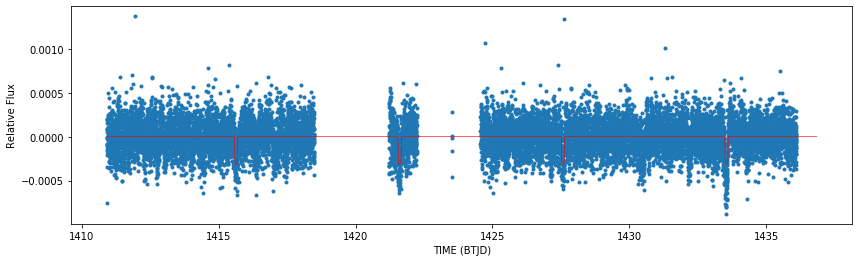

In [0]:
url = dvurl + str(ticid) + '/table/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tce_data = r.json()
data = p.DataFrame.from_dict(tce_data['data'])
data.columns
detrend = data['LC_DETREND']
model = data['MODEL_INIT']
time = data['TIME']

plt.figure(figsize=(14,4))
plt.plot(time,detrend,'.',lw=0.4)
plt.plot(time,model,'r-',lw=0.6)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Relative Flux')

Finally, this code is used to make a Bokeh plot of the phase light curve. A Bokeh plot is a light curve which is a folded on itself a lot of times and centered at the period of the TCE.

In [0]:
url = dvurl + str(ticid) + '/phaseplot/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
display(HTML(str(r.content.decode('utf-8'))))

#Exoplanet 2: LHS 3844 b

The process that was used for deriving the light curve for HR 858 c is the exact process that is used to also derive the light curve for LHS 3844 b.

Code used to access python dictionary of exoplanet.

In [0]:
planet_name = "LHS 3844 b"

url = planeturl + "/identifiers/"

myparams = {"name":planet_name}

r = requests.get(url = url, params = myparams, headers = header)
print(r.headers.get('content-type'))
planet_names = r.json()
ticid = planet_names['tessID']
tce = planet_names['tessTCE']
planet_names

application/json; charset=UTF-8


{'canonicalName': 'LHS 3844 b',
 'dec': -69.168986,
 'keplerID': None,
 'keplerTCE': None,
 'planetNames': [],
 'ra': 340.492104,
 'starName': 'LHS 3844',
 'tessID': 410153553,
 'tessTCE': 'TCE_1'}

Code used to retrieve properties of planet.

In [0]:
url = planeturl + planet_name + "/properties/"

r = requests.get(url = url, headers = header)

planet_prop = r.json()

print("Catalog 1: " + planet_prop[0]['catalog_name'])
planet_prop[0].keys()
print("LHS 3844 b Properties")
print("Stellar Mass %f %s" % (planet_prop[0]['Ms'], planet_prop[0]['Ms_unit'] ) )
print("Planet Mass %f %s" % (planet_prop[0]['Mp'], planet_prop[0]['Mp_unit'] ) )
print("Planet Mass Reference: %s" % (planet_prop[0]['Mp_ref']))

Catalog 1: nexsci
LHS 3844 b Properties
Stellar Mass 0.150000 M_sun
Planet Mass 0.007080 M_Jupiter
Planet Mass Reference: Calculated Value


Code used to locate the sector where the data is located and print the primary and dv data header.

In [0]:
url = dvurl + str(ticid) + '/tces/'
myparams = {"tce" : tce}

r = requests.get(url = url, params = myparams, headers = header)
sectorInfo = r.json()

sectors = [x[:11] for x in sectorInfo["TCE"] if tce in x]
sectors
url = dvurl + str(ticid) + '/info/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tceInfo = r.json()
tceInfo.keys()
tceInfo['DV Data Header'].keys()

print("TIC: %s" % tceInfo['DV Primary Header']['OBJECT'])
print("Planet Radius: %f" % tceInfo['DV Data Header']['PRADIUS'])

TIC: TIC 410153553
Planet Radius: 1.240476


Code used to retrieve the light curve.

Text(0, 0.5, 'Relative Flux')

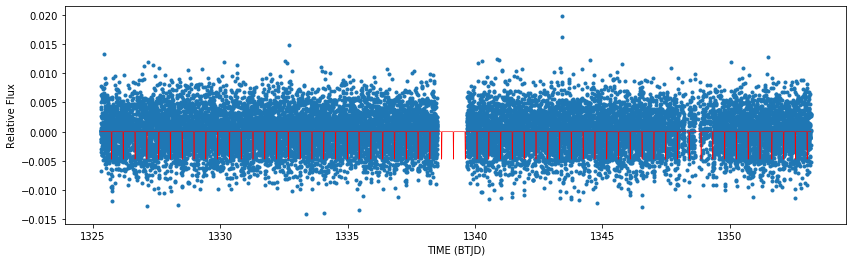

In [0]:
url = dvurl + str(ticid) + '/table/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
tce_data = r.json()
data = p.DataFrame.from_dict(tce_data['data'])
data.columns
detrend = data['LC_DETREND']
model = data['MODEL_INIT']
time = data['TIME']

plt.figure(figsize=(14,4))
plt.plot(time,detrend,'.',lw=0.4)
plt.plot(time,model,'r-',lw=0.6)
plt.xlabel('TIME (BTJD)')
plt.ylabel('Relative Flux')

Code used to make a Bokeh plot of the phase light curve.

In [0]:
url = dvurl + str(ticid) + '/phaseplot/'
myparams = {"tce" : tce,
            "sector" : sectors[0]}

r = requests.get(url = url, params = myparams, headers = header)
display(HTML(str(r.content.decode('utf-8'))))

#Retrieving a Cutout of TESS's Full Frame Images

#Exoplanet 1: HR 858 c

First, from the TIC ID associated with the exoplanet, a cone search is done using Catalogs.query_object on the TIC catalogue. From the code below, a table is made for all the objects that were detected during the cone search which includes the exoplanet and various nearby stars. This table includes the ID, Tmag, Jmag, RA(right ascension), dec(declination) and objType.

In [0]:
ticid = 178155732

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 15

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
print("Amount of nearby stars: ",len(nearbyStars))

    ID      Tmag   Jmag         ra               dec        objType
--------- ------- ------ ---------------- ----------------- -------
178155732  5.9053  5.473  42.984360089963 -30.8145164083075    STAR
651434979 14.9601    nan 42.9850261292083 -30.8122828731604    STAR
178170744  15.935 15.435        42.993834        -30.814581    STAR
651434978 19.9638    nan 42.9733349491913 -30.8160297533747    STAR
178170743   15.92 14.673        42.995532        -30.814583    STAR
Amount of nearby stars:  11


The code below is used to determine which sectors, which cameras and which CCD's contain data of the desired exoplanet. It should be mentioned that each sector contains 4 cameras which in turn contain 4 CCD's.

In [0]:
coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0003-2-2      3      2   2
tess-s0004-2-1      4      2   1


In the following code, the astrocut tool is used to deliver a zipped file containing a cutout for each set of FFI's. This returns a list of HDUlist objects.

In [0]:
hdulist = Tesscut.get_cutouts(coord, 20)
hdulist[0].info()

Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1288R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


The code below is used to plot the first image of the time series from the pixel-level data stored in the first PIXELS extention.

Text(0, 0.5, 'Image Row')

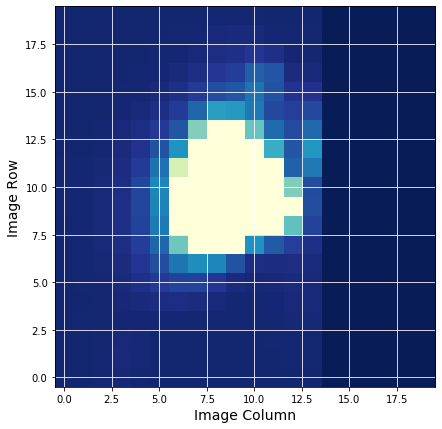

In [0]:
# Define a function to simplify the plotting command that we do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)

Finally, the code below is used to plot the same image with the y-axis refering to the declination and the x-axis refering to right ascenscion. Furthermore, a WCS(World Coordinate System) is used to place a red dot in the position of the desired star and to place several orange dots in the position of nearby stars found in the image.

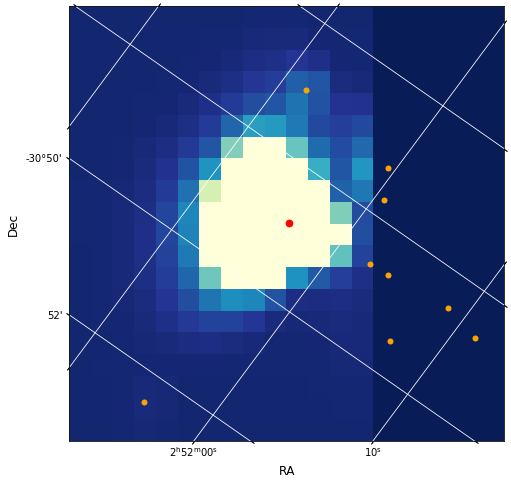

In [0]:
hdu2 = hdulist[0]

firstImage = hdu2[1].data['FLUX'][0]

wcs = WCS(hdu2[2].header)

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)


starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            s = 25, color = 'orange')

#Exoplanet 2: LHS 3844 b

The process that was used for retrieving a cutout of TESS's full frame images for HR 858 c is the exact same process that is used for LHS 3844 b as well.

First, the code that prints a table that includes the ID, Tmag, Jmag, ra, dec and objType is shown below.

In [0]:
ticid = 410153553

starName = "TIC " + str(ticid)
radSearch = 4/60 #radius in degrees

catalogData = Catalogs.query_object(starName, radius = radSearch, catalog = "TIC")
ra = catalogData[0]['ra']
dec = catalogData[0]['dec']

# Print out the first row in the table
print( catalogData[:5]['ID', 'Tmag', 'Jmag', 'ra', 'dec', 'objType'] )

# Create a list of nearby bright stars (tess magnitude less than 14) from the rest of the data for later.
bright = catalogData['Tmag'] < 15

# Make it a list of Ra, Dec pairs of the bright ones. This is now a list of nearby bright stars.
nearbyStars = list( map( lambda x,y:[x,y], catalogData[bright]['ra'], catalogData[bright]['dec'] ) )
print("Amount of nearby stars: ",len(nearbyStars))

    ID       Tmag   Jmag         ra               dec        objType
---------- ------- ------ ---------------- ----------------- -------
 410153553 11.9238 10.046  340.49215556875 -69.1689780353653    STAR
 410153559 16.6687  15.76 340.468442639808 -69.1766641540847    STAR
 410153556  16.722 15.411 340.525027405524 -69.1730885730915    STAR
 410153558 15.6977 14.835 340.456441765234 -69.1748598816247    STAR
2054808756 20.1405    nan  340.53200909292 -69.1725476191751    STAR
Amount of nearby stars:  3


Afterwards, the code to determine which sectors, cameras and CCD's contain the exoplanet is also shown below.

In [0]:
coord = SkyCoord(ra, dec, unit = "deg")

sectorTable = Tesscut.get_sectors(coord)
print(sectorTable)

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0001-3-2      1      3   2


Furthermore, a code used to retrieve a list of HDUlist objects is shown below.

In [0]:
hdulist = Tesscut.get_cutouts(coord, 20)
hdulist[0].info()



Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      55   ()      
  1  PIXELS        1 BinTableHDU    279   1282R x 12C   [D, E, J, 400J, 400E, 400E, 400E, 400E, J, E, E, 38A]   
  2  APERTURE      1 ImageHDU        79   (20, 20)   int32   


The code to plot the first image of the time series from the pixel-level data stored in the first PIXELS extension is below.

Text(0, 0.5, 'Image Row')

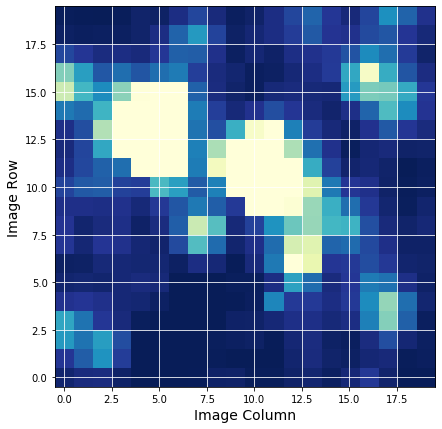

In [0]:
# Define a function to simplify the plotting command that we do repeatedly.
def plot_cutout(image):
    """
    Plot image and add grid lines.
    """
    plt.imshow(image, origin = 'lower', cmap = plt.cm.YlGnBu_r, 
           vmax = np.percentile(image, 92),
           vmin = np.percentile(image, 5))

    plt.grid(axis = 'both',color = 'white', ls = 'solid')

hdu1 = hdulist[0]
firstImage = hdu1[1].data['FLUX'][0]

fig = plt.figure(figsize=(7, 7))
plot_cutout(firstImage)
plt.xlabel('Image Column',fontsize = 14)
plt.ylabel('Image Row',fontsize = 14)

Finally, a code that places a WCS in the picture above can be seen below.

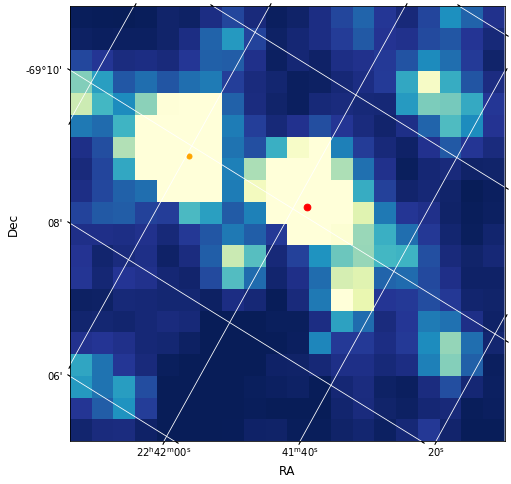

In [0]:
hdu2 = hdulist[0]

firstImage = hdu2[1].data['FLUX'][0]

wcs = WCS(hdu2[2].header)

fig = plt.figure(figsize = (8, 8))
fig.add_subplot(111, projection = wcs)
plot_cutout(firstImage)

plt.xlabel('RA', fontsize = 12)
plt.ylabel('Dec', fontsize = 12)


starloc = wcs.all_world2pix([[ra,dec]],0)  #Second is origin
plt.scatter(starloc[0,0], starloc[0,1],s = 45,color = 'red')

# Plot nearby stars as well, which we created using our Catalog call above.
nearbyLoc = wcs.all_world2pix(nearbyStars[1:],0)
plt.scatter(nearbyLoc[1:, 0], nearbyLoc[1:, 1], 
            s = 25, color = 'orange')